In [1]:
import numpy as np
from collections import Counter
from qiskit import IBMQ,Aer,schedule, execute, QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.tools.visualization import plot_histogram
from qiskit.visualization import timeline_drawer
from qiskit.visualization.pulse_v2 import draw, IQXDebugging
from qiskit.tools.monitor import job_monitor
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer import AerSimulator
import qiskit.quantum_info as qi
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.ignis.mitigation.measurement import (complete_meas_cal,CompleteMeasFitter,MeasurementFilter)

# Tomography functions
from qiskit_experiments.framework import ParallelExperiment
from qiskit_experiments.library import StateTomography


import KSEM
from importlib import reload  
KSEM = reload(KSEM)
from KSEM import KSQS, EMLearn

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# plt.rcParams['text.usetex'] = True
fig_size = (8,6)
fig_dpi = 150

In [2]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [30]:
provider = IBMQ.get_provider(hub="ibm-q-pnnl", group="internal", project="default")
name = "ibm_auckland"
backend = provider.get_backend(name)
backend_noise_model = NoiseModel.from_backend(backend)
data_folder = "Noisy_Id_Data/"

n_qubits = 3
reps = 8
max_num_itrs = 10

In [31]:
backend_noise_model.to_dict()['errors'][-1]

{'type': 'roerror',
 'operations': ['measure'],
 'probabilities': [[0.9946, 0.0054], [0.006800000000000028, 0.9932]],
 'gate_qubits': [(26,)]}

In [32]:
print(backend.properties().to_dict()[ 'last_update_date'])

2022-03-03 02:20:45-05:00


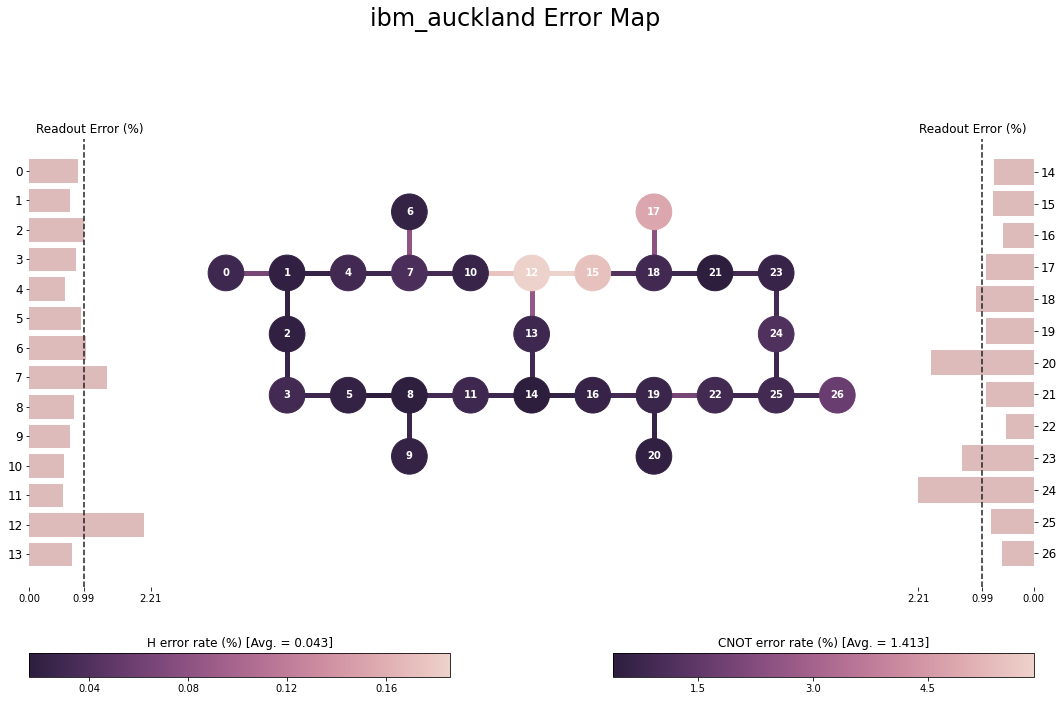

In [33]:
from qiskit.visualization import plot_error_map, plot_gate_map
%matplotlib inline

plot_error_map(backend, figsize=(18, 12))

In [34]:
from qiskit import Aer
def single_iter(n_qubits=2):
    iterate = QuantumCircuit(n_qubits)
    iterate.h(0)
    iterate.cx(0,1)
    iterate.cx(1,2)
    iterate.barrier()
    iterate.cx(1,2)
    iterate.cx(0,1)
    iterate.h(0)
    iterate.barrier()
    return iterate

def iterative_circ(num_itrs, n_qubits=2, save_den = True):   
    total_circ = QuantumCircuit(n_qubits)
    for i in range(num_itrs):
        total_circ.compose(single_iter(n_qubits), inplace=True)
    if save_den:
        total_circ.save_density_matrix(pershot=False)
    total_circ.measure_all()
    return total_circ

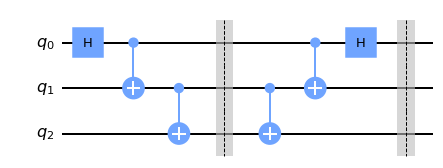

In [35]:
single_iter(n_qubits).draw("mpl")

10


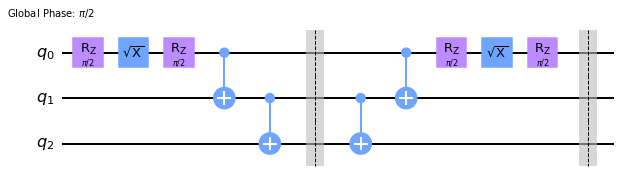

In [36]:
temp_circ = transpile(single_iter(n_qubits), backend=den_simu)
print(temp_circ.depth())
temp_circ.draw("mpl")

In [37]:
temp_circ2 = iterative_circ(max_num_itrs, n_qubits, save_den = False)
temp_circ3 = transpile(temp_circ2, backend=backend)
print("Depth:", temp_circ3.depth())
print("T1:", backend.properties().qubit_property(0)['T1'][0], "sec")
print("T2:", backend.properties().qubit_property(0)['T2'][0], "sec")
dt = backend.configuration().dt # sec
temp_sch = schedule(temp_circ3, backend)
print("Circuit Operation Time:",(temp_sch.stop_time - temp_sch.start_time)*dt, "sec")

Depth: 101
T1: 0.0001539106029643501 sec
T2: 0.00014317203625378966 sec
Circuit Operation Time: 3.545955555555555e-05 sec


## Collect Measurement Data from Real Machine

In [39]:
# job_list = []
# for i in range(1, max_num_itrs+1):
#     trans_circ = transpile(iterative_circ(i, n_qubits, save_den = False), backend=backend).copy(name=str(i))
#     job_list.append(trans_circ)
# iter_job = execute(job_list,shots=8192,backend=backend)
# job_monitor(iter_job)

Job Status: job has successfully run


In [57]:
# print(iter_job.job_id()) # 622080ce762eb77b0981c7d5

622080ce762eb77b0981c7d5


In [51]:
# real_probs = [] # measurement result
# for i in range(1, max_num_itrs+1):
#     iter_res = iter_job.result()
#     iter_vec = KSEM.dictToVec(iter_res.get_counts(str(i)))
#     real_probs.append(iter_vec)
    
# # Save to numpy
# np.save(data_folder+backend.properties().to_dict()['backend_name']+'_meas_vec.npy',np.array(real_probs))

In [ ]:
# Load
real_probs = np.load(data_folder+backend.properties().to_dict()['backend_name']+'_meas_vec.npy')

## Qiskit Backend-noise Simulation

Obtain measurement data and actual quantum states (from a backend-noise simulator)

Note that the outputs does not have measurement noise because the probabilities are obtained from density matrix object, instead of measurement operator API.

In [70]:
backend_noise_model = NoiseModel.from_backend(backend)
# # Remove readout errros
# p0given1 = 0
# p1given0 = 0
# rde = ReadoutError([[1 - p1given0, p1given0], [p0given1, 1 - p0given1]])
# for i in range(backend.configuration().num_qubits):
#     backend_noise_model._local_readout_errors[(i,)] = rde
den_simu = AerSimulator(method='density_matrix',noise_model=backend_noise_model)

In [115]:
# # Obtain Measurement Error Matrix
# qr = QuantumRegister(n_qubits)
# meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')
# for i in range(len(meas_calibs)):
#     meas_calibs[i] = transpile(meas_calibs[i],den_simu)

# job_meas = den_simu.run(meas_calibs,shots=reps*8192,optimization_level=0)
# cal_results = job_meas.result()
# meas_fitter = CompleteMeasFitter(cal_results,state_labels,circlabel='mcal')
# meas_filter = meas_fitter.filter
# cal_mat= meas_filter.cal_matrix
# np.save(data_folder+backend.properties().to_dict()['backend_name']+'_cal_mat.npy', cal_mat)

In [116]:
cal_mat = np.load(data_folder+backend.properties().to_dict()['backend_name']+'_cal_mat.npy')
cal_mat

array([[9.82299805e-01, 1.19476318e-02, 1.08032227e-02, 9.15527344e-05,
        1.37176514e-02, 2.13623047e-04, 6.10351562e-05, 0.00000000e+00],
       [6.08825684e-03, 9.77020264e-01, 7.62939453e-05, 1.05438232e-02,
        6.10351562e-05, 1.35345459e-02, 0.00000000e+00, 1.22070312e-04],
       [4.50134277e-03, 7.62939453e-05, 9.75265503e-01, 1.14440918e-02,
        0.00000000e+00, 0.00000000e+00, 1.28784180e-02, 1.37329102e-04],
       [1.52587891e-05, 4.44030762e-03, 6.77490234e-03, 9.71771240e-01,
        0.00000000e+00, 4.57763672e-05, 7.62939453e-05, 1.29394531e-02],
       [7.01904297e-03, 6.10351562e-05, 4.57763672e-05, 0.00000000e+00,
        9.76150513e-01, 1.17187500e-02, 1.03149414e-02, 1.37329102e-04],
       [4.57763672e-05, 6.45446777e-03, 0.00000000e+00, 6.10351562e-05,
        5.98144531e-03, 9.70123291e-01, 3.05175781e-05, 1.06506348e-02],
       [3.05175781e-05, 0.00000000e+00, 7.03430176e-03, 6.10351562e-05,
        4.04357910e-03, 3.05175781e-05, 9.70932007e-01, 1.

In [71]:
unitary_simulator = Aer.get_backend('aer_simulator')
unitary_circ = transpile(single_iter(n_qubits), backend=den_simu)
unitary_circ.save_unitary()
unitary_result = unitary_simulator.run(unitary_circ).result()
unitary = unitary_result.get_unitary(unitary_circ)

unitaries = []
for i in range(1, max_num_itrs+1):
    gate = unitary.data
    F = np.kron(gate.conjugate(), gate)
    unitaries.append(F)

In [72]:
trans_circ = transpile(iterative_circ(3, n_qubits), backend=den_simu)
iter_res = den_simu.run(trans_circ,shots=8192*reps,seed_simulator=np.random.randint(10**8)).result()
iter_res.get_counts()

{'000': 55662,
 '011': 2109,
 '111': 338,
 '001': 3574,
 '100': 658,
 '110': 322,
 '010': 2505,
 '101': 368}

In [73]:
np.random.seed(7)


total_simu_dens = [] # quantum state in density-matrix form
total_simu_probs = [] # measurement result
total_simu_purs = [] # purity
for i in range(1, max_num_itrs+1):
    trans_circ = transpile(iterative_circ(i, n_qubits), backend=den_simu)
    iter_res = den_simu.run(trans_circ,shots=8192*reps,seed_simulator=np.random.randint(10**8)).result()
    iter_den = iter_res.data()['density_matrix']
    total_simu_dens.append(iter_den)
    total_simu_probs.append(KSEM.dictToVec(iter_res.get_counts()))
    total_simu_purs.append(np.real(iter_den.purity()))
    
print("Purity")
for pu in total_simu_purs:
    print(pu)
    
print("\nProb Vec")
for p in total_simu_probs:
    print(p)

Purity
0.9064696112887533
0.8248552728649341
0.7536002767988893
0.6913530300018977
0.6369398771599033
0.5893415420895772
0.5476727035086321
0.5111642862523711
0.4791481052281023
0.45104354806918673

Prob Vec
[0.93612671 0.02328491 0.01512146 0.0125885  0.00738525 0.00187683
 0.00184631 0.00177002]
[0.89361572 0.03807068 0.02763367 0.02212524 0.00837708 0.0032959
 0.00370789 0.00317383]
[0.85028076 0.05517578 0.03582764 0.03338623 0.01010132 0.00538635
 0.00520325 0.00463867]
[0.80961609 0.06951904 0.04672241 0.04211426 0.01213074 0.00682068
 0.00666809 0.00640869]
[0.77534485 0.08078003 0.05290222 0.05181885 0.01405334 0.00881958
 0.00784302 0.00843811]
[0.7436676  0.09147644 0.06230164 0.05987549 0.01347351 0.00967407
 0.01000977 0.00952148]
[0.71022034 0.10389709 0.07026672 0.06437683 0.016922   0.01226807
 0.01150513 0.01054382]
[0.68061829 0.11587524 0.07559204 0.0740509  0.01721191 0.01229858
 0.01211548 0.01223755]
[0.65179443 0.12515259 0.08273315 0.08009338 0.01841736 0.0154418

## Kalman Smoother

In [74]:
def vecden_meas(state):# H, measurement matrix for vectorized density matrix
    num_qubits = int(np.log2(np.sqrt(state.shape[0])))
    nrows = 2**num_qubits
    ncols = nrows**2
    mat = np.zeros((nrows, ncols), dtype=np.float64)
    for k in range(nrows):
        mat[k, nrows*k+k] = 1.0 # take out the diagonal terms in vectorized density matrix
    return np.real(mat.dot(state))

### Initialize

In [75]:
real_probs

[array([0.91125488, 0.0234375 , 0.02880859, 0.01843262, 0.0057373 ,
        0.0020752 , 0.00390625, 0.00634766]),
 array([0.83984375, 0.04089355, 0.04956055, 0.03491211, 0.00976562,
        0.00170898, 0.01281738, 0.01049805]),
 array([0.75439453, 0.05480957, 0.08105469, 0.05566406, 0.01391602,
        0.0045166 , 0.01391602, 0.02172852]),
 array([0.67578125, 0.07739258, 0.09387207, 0.07763672, 0.01611328,
        0.00671387, 0.02539062, 0.02709961]),
 array([0.61730957, 0.09460449, 0.11022949, 0.09606934, 0.01599121,
        0.0098877 , 0.0267334 , 0.0291748 ]),
 array([0.54394531, 0.11975098, 0.12524414, 0.11376953, 0.01721191,
        0.01293945, 0.03173828, 0.03540039]),
 array([0.49121094, 0.12780762, 0.15014648, 0.13122559, 0.02124023,
        0.0144043 , 0.02758789, 0.03637695]),
 array([0.45751953, 0.14343262, 0.15393066, 0.13818359, 0.0213623 ,
        0.01782227, 0.03161621, 0.03613281]),
 array([0.40234375, 0.15197754, 0.17211914, 0.15490723, 0.02893066,
        0.02050781, 

In [76]:
initial_state = np.array([0]*(real_probs[0].size**2), dtype=complex)
initial_state[0] = 1

# initial state
num_dim = initial_state.size
x =initial_state
x[0]-= 0.01/num_dim
nrows = int(x.size-1)
for k in range(1,nrows+1):
    x[k] += 1/(num_dim*nrows)

In [77]:
# Other variance parameters
num_dim_state = initial_state.size
num_dim_obs = real_probs[0].size

M = np.identity(num_dim_state, dtype=complex)* 0.01 * (1) # a guess for covariance matrix, E[(x0-xhat0^+)(x0-xhat0^+)^T]
Q = np.identity(num_dim_state, dtype=complex)* 0.2 * (1) # state covariance
R = np.identity(num_dim_obs)* 0.2 * (1) # meas covariance
P = np.identity(num_dim_state, dtype=complex)* 0.1 * (1+1j)# 
# U = np.identity(num_dim_obs, dtype=complex)* 0.0

In [78]:
x.size,num_dim_state,num_dim_obs, unitaries[0].size

(64, 64, 8, 4096)

### EM and Smoother - Total

Use longest iterations

In [79]:
# total_smoother_dens = []
# total_smoother_purs = []

# observs = total_simu_probs
# learn_obj = EMLearn(observs, unitaries[0], x, M, Q, R, P, U)
# estX0, estM0, estQ, estR, estF = learn_obj.learn() # they are all arguemented

# # Slice from argumented system
# realX0 = estX0.toarray()[:num_dim_state]
# realX0norm = np.sqrt(np.sum(np.abs(realX0)**2))
# realM0 = estM0.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
# realF = estF.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
# realQ = estQ.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
# realR = estR.toarray()[range(num_dim_obs),:][:,range(num_dim_obs)]
# realP = estQ.toarray()[range(num_dim_state),:][:,range(num_dim_state, 2*num_dim_state)]
# realU = estR.toarray()[range(num_dim_obs),:][:,range(num_dim_obs, 2*num_dim_obs)]

# smoother = KSQS(observs, realF, x, realM0, realQ, realR, realP, realU)
# x_seq, M_seq, M_prio_seq = smoother.smooth() 

# x_est_norms = []
# for j in range(max_num_itrs):
#     x_est = np.array(x_seq[j+1][:num_dim_state].todense()).flatten()
#     diag_sum = np.sum(vecden_meas(x_est))

#     #normalize along the diagonal
#     x_est_norm = x_est+0
#     nrows = int(np.sqrt(x_est.size))
#     for k in range(nrows):
#         x_est_norm[k*nrows+k] = x_est_norm[k*nrows+k]/diag_sum
#     x_est_norms.append(x_est_norm)
#     final_den = x_est_norm.reshape(num_dim_obs, num_dim_obs)
#     total_smoother_dens.append(final_den)
#     total_smoother_purs.append(np.real(qi.DensityMatrix(final_den).purity()))

Only use the estimation in the final iteration as the valid output

In [80]:
total_smoother_dens = []
total_smoother_purs = []
for i in range(1,max_num_itrs+1):
    observs = real_probs[0:i]
    learn_obj = EMLearn(observs, unitaries[0], x, M, Q, R, P)
    estX0, estM0, estQ, estR, estF = learn_obj.learn() # they are all arguemented
    
    # Slice from argumented system
    realX0 = estX0.toarray()[:num_dim_state]
    realX0norm = np.sqrt(np.sum(np.abs(realX0)**2))
    realM0 = estM0.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
    realF = estF.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
    realQ = estQ.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
    realR = estR.toarray()[range(num_dim_obs),:][:,range(num_dim_obs)]
    realP = estQ.toarray()[range(num_dim_state),:][:,range(num_dim_state, 2*num_dim_state)]
    realU = estR.toarray()[range(num_dim_obs),:][:,range(num_dim_obs, 2*num_dim_obs)]*0

    smoother = KSQS(observs, realF, x, realM0, realQ, realR, realP)
    x_seq, M_seq, M_prio_seq = smoother.smooth() 
    
    # Normalization
#     x_est_norms = []
#     for j in range(i):
#         x_est = np.array(x_seq[j+1][:num_dim_state].todense()).flatten()
#         diag_sum = np.sum(vecden_meas(x_est))

#         #normalize along the diagonal
#         x_est_norm = x_est+0
#         nrows = int(np.sqrt(x_est.size))
#         for k in range(nrows):
#             x_est_norm[k*nrows+k] = x_est_norm[k*nrows+k]/diag_sum
#     final_den = x_est_norm.reshape(num_dim_obs, num_dim_obs)

    x_est = np.matrix(x_seq[-1][:num_dim_state].todense()).flatten().reshape(num_dim_obs, num_dim_obs)
    x_est = (x_est+x_est.H)/2
    final_den = KSEM.closed_den_mat(x_est)
    total_smoother_dens.append(final_den)
    total_smoother_purs.append(np.real(qi.DensityMatrix(final_den).purity()))

C:\ProgramData\Anaconda3\envs\quantum\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\ProgramData\Anaconda3\envs\quantum\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\ProgramData\Anaconda3\envs\quantum\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


Iteration     1, New log-likelihood 2.91920e+02, Last log-likelihood 2.93598e+02, Change -1.67757e+00
Iteration     1, New log-likelihood 1.43895e+02, Last log-likelihood 2.52061e+02, Change -1.08166e+02
Iteration     1, New log-likelihood -6.32090e+03, Last log-likelihood -1.18391e+03, Change -5.13700e+03
Iteration     1, New log-likelihood -7.12123e+05, Last log-likelihood -2.00953e+04, Change -6.92028e+05
Iteration     1, New log-likelihood -2.78787e+08, Last log-likelihood -2.49966e+05, Change -2.78537e+08
Iteration     1, New log-likelihood -1.04687e+11, Last log-likelihood -2.98562e+06, Change -1.04684e+11
Iteration     1, New log-likelihood -3.58495e+13, Last log-likelihood -3.51697e+07, Change -3.58494e+13
Iteration     1, New log-likelihood -1.17536e+16, Last log-likelihood -4.11694e+08, Change -1.17536e+16
Iteration     1, New log-likelihood -3.75323e+18, Last log-likelihood -4.81328e+09, Change -3.75323e+18
Iteration     1, New log-likelihood -1.17439e+21, Last log-likelihoo

In [81]:
for den in total_smoother_dens:
    print("Is state a valid density matrix:", qi.DensityMatrix(den).is_valid())

Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True


In [82]:
with np.printoptions(precision=3, suppress=True):
#     for den in total_smoother_dens:
#         print(den)
    print(total_smoother_dens[8])
    print(total_simu_dens[8].data)

[[ 0.428+0.j -0.   +0.j -0.   +0.j -0.   +0.j -0.   +0.j -0.   +0.j
  -0.   +0.j -0.   +0.j]
 [-0.   +0.j  0.148+0.j  0.   +0.j  0.   +0.j -0.   +0.j -0.   +0.j
  -0.   +0.j -0.   +0.j]
 [-0.   +0.j  0.   +0.j  0.148+0.j  0.004+0.j -0.   +0.j -0.   +0.j
  -0.   +0.j -0.   +0.j]
 [-0.   +0.j  0.   +0.j  0.004+0.j  0.163+0.j -0.   +0.j -0.   +0.j
  -0.   +0.j -0.   +0.j]
 [-0.   +0.j -0.   +0.j -0.   +0.j -0.   +0.j  0.033+0.j -0.   +0.j
   0.   +0.j  0.   +0.j]
 [-0.   +0.j -0.   +0.j -0.   +0.j -0.   +0.j -0.   +0.j  0.035+0.j
   0.   +0.j  0.   +0.j]
 [-0.   +0.j -0.   +0.j -0.   +0.j -0.   +0.j  0.   +0.j  0.   +0.j
   0.019+0.j  0.001+0.j]
 [-0.   +0.j -0.   +0.j -0.   +0.j -0.   +0.j  0.   +0.j  0.   +0.j
   0.001+0.j  0.026+0.j]]
[[ 0.664+0.j  0.072+0.j  0.   +0.j  0.   +0.j  0.   +0.j  0.   +0.j
   0.   +0.j  0.   +0.j]
 [ 0.072+0.j  0.121+0.j  0.   +0.j  0.   +0.j  0.   +0.j  0.   +0.j
   0.   +0.j  0.   +0.j]
 [ 0.   +0.j  0.   +0.j  0.08 +0.j  0.001+0.j  0.   +0.j  0.   +0.j
 

In [83]:
print("Estimated Purity (Total)")
for pu in total_smoother_purs:
    print(pu)

Estimated Purity (Total)
0.8987886735031809
0.7735230035734463
0.6432587104466028
0.5305639354416879
0.45002392609829717
0.3748790254128355
0.3229902838648214
0.2905052076834389
0.25684436651517756
0.23584795761817887


## Check the fidelity between estimated state and the real state in the simulator

In [84]:
from scipy.linalg import sqrtm
def state_fid(m1,m2):
    sqm1 = sqrtm(m1)
    temp = sqm1.dot(m2).dot(sqm1)
    temp2 = sqrtm(temp)
    return np.real(np.trace(temp2))**2

def dist(p,q):
    return np.abs(p-q).sum()*0.5

Iteration 1 KS Dist: 0.024679202367177983 Simu Dist: 0.04039166452335914
Iteration 2 KS Dist: 0.033196915448956726 Simu Dist: 0.0682109746619949
Iteration 3 KS Dist: 0.03310431584390057 Simu Dist: 0.1103077346536667
Iteration 4 KS Dist: 0.13341093030854922 Simu Dist: 0.14917639875529012
Iteration 5 KS Dist: 0.057742782510905345 Simu Dist: 0.17086466434734526
Iteration 6 KS Dist: 0.06448753096587806 Simu Dist: 0.20986406866877513
Iteration 7 KS Dist: 0.04668059140248897 Simu Dist: 0.23048801853480483
Iteration 8 KS Dist: 0.020053084627801317 Simu Dist: 0.23417050975630208
Iteration 9 KS Dist: 0.04970047001393302 Simu Dist: 0.2612964133748891
Iteration 10 KS Dist: 0.021352579919473105 Simu Dist: 0.2669331819107594


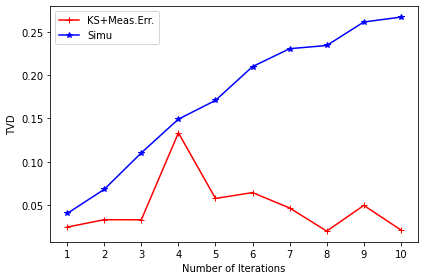

In [119]:
diff_fed_all= []
diff_fed_simu= []
for i in range(max_num_itrs):
    fed_difference_simu =  dist(real_probs[i].data, total_simu_dens[i].probabilities())
    KS_vec = np.array(total_smoother_dens[i].diagonal()).flatten().real
    noisy_KS_vec = cal_mat.dot(KS_vec)
    fed_difference_all =  dist(real_probs[i].data, noisy_KS_vec)
    diff_fed_all.append(fed_difference_all)
    diff_fed_simu.append(fed_difference_simu)
    print("Iteration",i+1, "KS Dist:", fed_difference_all, "Simu Dist:", fed_difference_simu)
    
iter_range = range(max_num_itrs)
plt.plot(np.array(iter_range)+1, np.array(diff_fed_all)[iter_range], '+-', color='red', label='KS+Meas.Err.')
plt.plot(np.array(iter_range)+1, np.array(diff_fed_simu)[iter_range], '*-', color='blue', label='Simu')
plt.xlabel("Number of Iterations")
plt.ylabel("TVD")
plt.xticks((np.array(iter_range)+1))
plt.legend()
plt.tight_layout()
plt.savefig(data_folder+backend.properties().to_dict()['backend_name']+"_diff_dist.svg")
plt.show()